In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mne.io import RawArray
from mne import create_info
from mne.preprocessing import ICA

In [2]:
%matplotlib notebook

In [8]:
%matplotlib inline

In [3]:
data = np.load('preICA.npy')

In [4]:
data.shape

(195, 11796177)

In [5]:
info_e = create_info(data.shape[0], 1000, 'eeg')
raw_e = []
num = 80
for i in range(num - 1):
    raw_e.append(
        RawArray(
            data[:,int(i * data.shape[1] / num) : int((i+2) * data.shape[1] / num)],
            info_e
        )
    )

Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294905
    Range : 0 ... 294904 =      0.000 ...   294.904 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294905
    Range : 0 ... 294904 =      0.000 ...   294.904 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Rang

    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294905
    Range : 0 ... 294904 =      0.000 ...   294.904 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294905
    Range : 0 ... 294904 =      0.000 ...   294.904 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294904
    Range : 0 ... 294903 =      0.000 ...   294.903 secs
Ready.
Creating RawArray with float64 data, n_channels=195, n_times=294905
    Range : 0 ... 294904 =      0.000 ...   294.904 secs
Ready.
Creating Raw

In [12]:
info_m = create_info(data.shape[0], 1000, 'misc')

In [13]:
raw_m = RawArray(data, info_m)

Creating RawArray with float64 data, n_channels=195, n_times=11796177
    Range : 0 ... 11796176 =      0.000 ... 11796.176 secs
Ready.


<IPython.core.display.Javascript object>


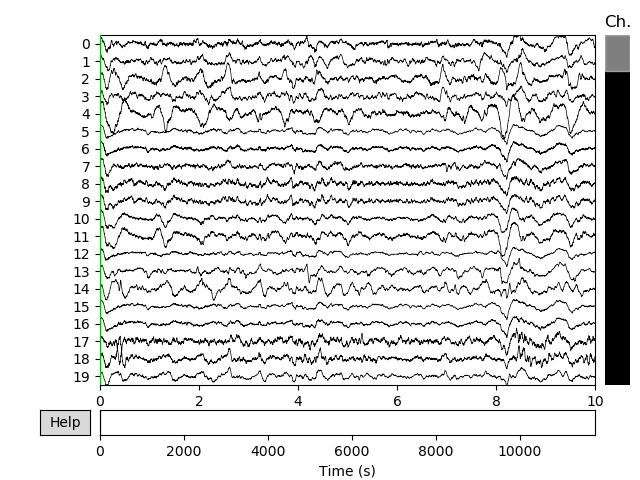

In [14]:
fig = raw_m.plot(n_channels=20)

In [6]:
def cosine_dist(A,B):
    M = np.empty((A.shape[0], B.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            M[i][j] = np.dot(A[i], B[j]) / (np.linalg.norm(A[i]) * np.linalg.norm(B[j]))
    return(M)

In [7]:
def get_ica(raw, num_segments, num_components):
    ica = []
    for i in range(num_segments):
        print('Segment Num = ', str(i))
        ica.append(
            ICA(max_pca_components=None, n_components=num_components, method='picard')
        )
        ica[i].fit(raw[i], picks='all')
    return(ica)

In [8]:
def get_ics_from_ICA(raw, ica):
    data = []
    for i in range(len(ica)):
        data.append(ica[i].get_sources(raw[i].load_data())._data)
    return(data)

In [9]:
def get_full_ics(data, shape, num):
    stability = []
    sources = data[0][:, : int(shape[1] / num)]
    for i in range(len(data) - 1):
        a = data[i][:, int((i+1) * shape[1] / num) - int(i * shape[1] / num) : ]
        b = data[i+1][:, : int((i+2) * shape[1] / num) - int((i+1) * shape[1] / num)]
        M = np.abs(cosine_dist(a, b))
        sources = np.concatenate((sources, b[np.argmax(M, axis=1)]), axis=1)[np.argmax(M, axis=0)]
        stability.append(sum(np.max(M, axis=0)) / len(M))
    sources = np.concatenate((sources, data[i+1][:, int((i+2) * shape[1] / num) - int((i+1) * shape[1] / num) : ]), axis=1)
    print('Stability between segments = ', stability)
    return(sources)

In [10]:
def get_weights(ica):
    weights = []
    for i in range(len(ica)):
        weights.append(np.transpose(ica[i].get_components()))
    return(weights)

In [11]:
def get_sources_from_scratch(raw, num_segments, num_components, shape, num):
    ica = get_ica(raw, num_segments, num_components)
    weights = get_weights(ica)
    data = get_ics_from_ICA(raw, ica)
    sources = get_full_ics(data, shape, num)
    return(sources, weights)

In [12]:
def plot_sources(sources):
    info_m = create_info(sources.shape[0], 1000, 'misc')
    raw_m = RawArray(sources, info_m)
    fig = raw_m.plot(n_channels=20)

In [13]:
def weight_stability(weights):
    stability = []
    for i in range(len(weights) - 1):
        stability.append(sum(np.max(np.abs(cosine_dist(weights[i], weights[i+1])), axis=0)) / len(weights[0]))
    print(stability)

In [137]:
ica1 = get_sources_from_scratch(raw_e, 5, 1, data.shape, num)

Segment Num =  0
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 1 components
Fitting ICA took 13.3s.
Segment Num =  1
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 1 components
Fitting ICA took 13.2s.
Segment Num =  2
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 1 components
Fitting ICA took 13.2s.
Segment Num =  3
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 1 components
Fitting ICA took 13.1s.
Segment Num =  4
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 1 components
Fitting ICA took 13.2s.
Stability betwe

In [136]:
ica2 = get_sources_from_scratch(raw_e, 5, 2, data.shape, num)

Segment Num =  0
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 13.3s.
Segment Num =  1
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 14.9s.
Segment Num =  2
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 19.3s.
Segment Num =  3
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 18.9s.
Segment Num =  4
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 13.8s.
Stability betwe

In [167]:
ica3, weights3 = get_sources_from_scratch(raw_e, 5, 3, data.shape, num)

Segment Num =  0
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 3 components
Fitting ICA took 20.7s.
Segment Num =  1
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 3 components
Fitting ICA took 16.3s.
Segment Num =  2
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 3 components
Fitting ICA took 15.5s.
Segment Num =  3
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 3 components
Fitting ICA took 15.7s.
Segment Num =  4
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 3 components
Fitting ICA took 14.8s.
Stability betwe

In [169]:
weight_stability(weights3)

[0.9927455824037165, 0.9932399269148665, 0.9846154704441424, 0.9903363004781108]


<IPython.core.display.Javascript object>


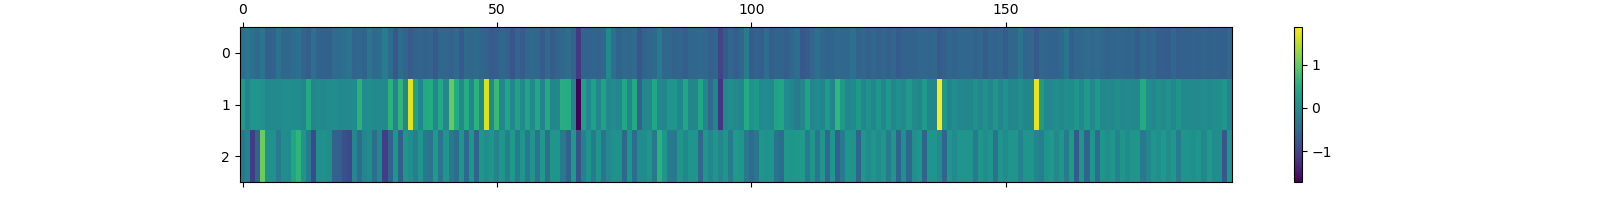

In [172]:
plt.matshow(weights3[0], aspect='auto')
plt.colorbar()

In [124]:
ica4 = get_sources_from_scratch(raw_e, 5, 4, data.shape, num)

Segment Num =  0
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 4 components
Fitting ICA took 16.0s.
Segment Num =  1
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 4 components
Fitting ICA took 15.2s.
Segment Num =  2
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 4 components
Fitting ICA took 15.2s.
Segment Num =  3
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 4 components
Fitting ICA took 14.5s.
Segment Num =  4
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 4 components
Fitting ICA took 15.5s.
Stability betwe

Creating RawArray with float64 data, n_channels=4, n_times=884713
    Range : 0 ... 884712 =      0.000 ...   884.712 secs
Ready.


<IPython.core.display.Javascript object>


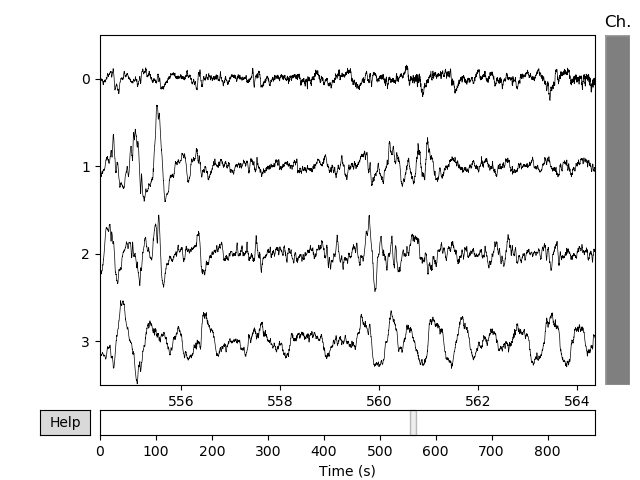

In [125]:
plot_sources(ica4)

In [126]:
ica5 = get_sources_from_scratch(raw_e, 5, 5, data.shape, num)

Segment Num =  0
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 20.8s.
Segment Num =  1
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 15.7s.
Segment Num =  2
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 16.0s.
Segment Num =  3
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 16.6s.
Segment Num =  4
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 22.7s.
Stability betwe

<IPython.core.display.Javascript object>


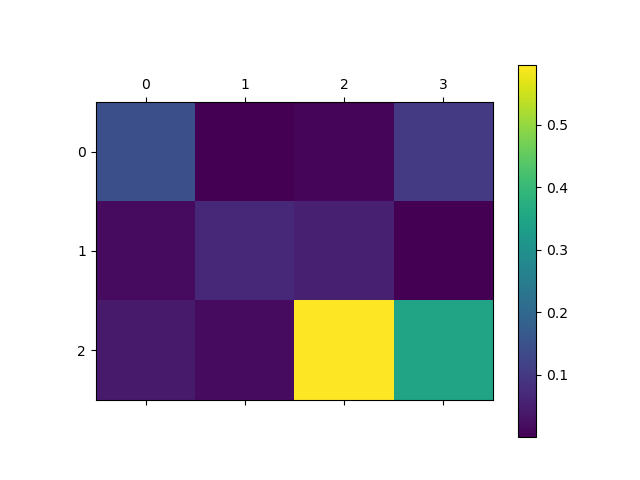

In [170]:
plt.matshow(np.abs(cosine_dist(ica3, ica4)))
plt.colorbar()

### Removing first component

In [3]:
def cosine_dist_along_axis(A,B):
    M = np.empty(A.shape[0])
    for i in range(A.shape[0]):
        M[i] = np.dot(A[i], B[i]) / (np.linalg.norm(A[i]) * np.linalg.norm(B[i]))
    return(M)

In [3]:
def get_reconstruction(data, shape, num):
    #stability = []
    sources = data[0][:, : int(shape[1] / num)]
    for i in range(len(data) - 1):
        #a = data[i][:, int((i+1) * shape[1] / num) - int(i * shape[1] / num) : ]
        b = data[i+1][:, : int((i+2) * shape[1] / num) - int((i+1) * shape[1] / num)]
        #M = np.abs(cosine_dist_along_axis(a, b))
        sources = np.concatenate((sources, b), axis=1)
        #stability.append(sum(M) / len(M))
    sources = np.concatenate((sources, data[i+1][:, int((i+2) * shape[1] / num) - int((i+1) * shape[1] / num) : ]), axis=1)
    #print('Stability between segments = ', stability)
    return(sources)

In [16]:
ics2 = get_ica(raw_e, 79, 2)

Segment Num =  0
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 17.6s.
Segment Num =  1
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 18.2s.
Segment Num =  2
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 25.2s.
Segment Num =  3
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 13.4s.
Segment Num =  4
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 13.5s.
Segment Num =  

Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 13.6s.
Segment Num =  42
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 13.9s.
Segment Num =  43
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 38.1s.
Segment Num =  44
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 13.7s.
Segment Num =  45
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 19.6s.
Segment Num =  46
Fitting ICA to data using 195 channels (please be patient, this may take a while)
Inferring 

In [17]:
weights2rem = get_weights(ics2)

In [18]:
reconst_raw = []
for i in range(len(weights2rem)):
    idx = np.argmin(np.var(weights2rem[i], axis=1))
    reconst_raw.append(raw_e[i].copy())
    ics2[i].apply(reconst_raw[i], exclude=[idx])

Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA space (2 components)
Zeroing out 1 ICA components
Transforming to ICA 

In [19]:
reconst_data_split = []
for i in range(len(reconst_raw)):
    reconst_data_split.append(reconst_raw[i]._data)

In [44]:
for i in range(len(reconst_data_split)):
    np.save('reconst_data_split'+str(i), reconst_data_split[i])

In [3]:
reconst_data_split = []
for i in range(79):
    print(i)
    reconst_data_split.append(np.load('reconst_data_split'+str(i)+'.npy'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [4]:
shape = (195, 11796177)

In [5]:
num = 80

In [6]:
for i in range(len(reconst_data_split) - 1):
    reconst_data_split[i] = reconst_data_split[i][:, : int((i+1) * shape[1] / num) - int(i * shape[1] / num)]

In [12]:
reconst_data = np.hstack(reconst_data_split)

In [14]:
np.save('reconst', reconst_data)

In [3]:
reconst_data = np.load('reconst.npy')

In [4]:
info_rec = create_info(reconst_data.shape[0], 1000, 'misc')
raw_rec = RawArray(reconst_data, info_rec)

Creating RawArray with float64 data, n_channels=195, n_times=11796177
    Range : 0 ... 11796176 =      0.000 ... 11796.176 secs
Ready.


<IPython.core.display.Javascript object>


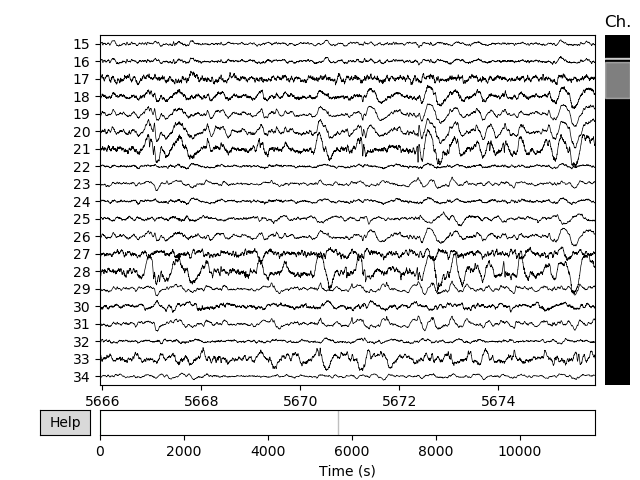

In [5]:
fig = raw_rec.plot(n_channels=20)

### Combining true traces and "Cleaned" traces

In [7]:
reconst_data = np.load('reconst.npy')

In [16]:
%matplotlib notebook
from matplotlib.widgets import Slider

In [27]:
Slider?

<IPython.core.display.Javascript object>


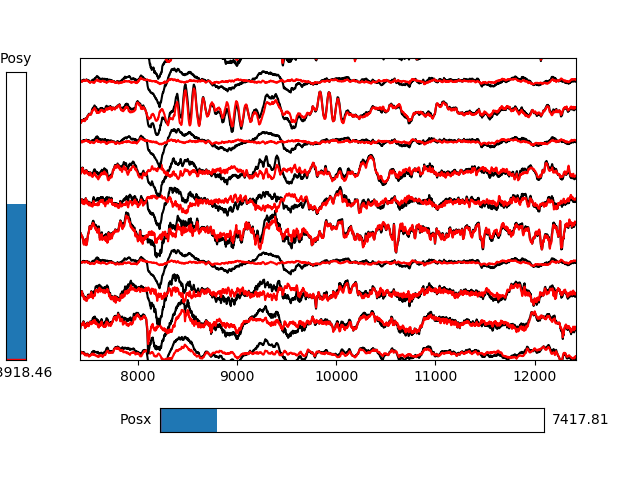

In [38]:
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

m = 19
minRange = 0
maxRange = 5000
offset = 5000
numPlots = 195
xrange = 50000

plt.yticks([], [])

for i in range(numPlots):
    plt.plot(data[i][0:xrange] + offset*i, 'k')
    plt.plot(reconst_data[i][0:xrange] + offset*i, 'r')
    

plt.axis([minRange, maxRange, -offset, (10-1)*offset])

axposy = plt.axes([0.01, 0.25, 0.03, 0.60])
axposx = plt.axes([0.25, 0.1, 0.60, 0.05])

sposy = Slider(axposy, 'Posy', -offset, (numPlots-1)*offset, orientation='vertical')
sposx = Slider(axposx, 'Posx', 0, xrange, orientation='horizontal')

def update(val):
    posy = sposy.val
    posx = sposx.val
    #posx = 0
    ax.axis([posx,posx+5000,posy,posy+10*offset])
    fig.canvas.draw_idle()

sposy.on_changed(update)
sposx.on_changed(update)

plt.show()

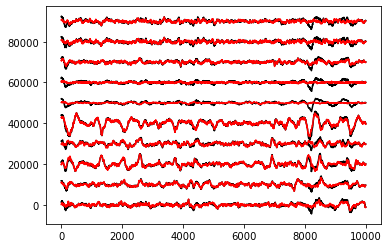

In [15]:
for i in range(10):
    plt.plot(data[i][:10000] + 10000*i, 'k')
    plt.plot(reconst_data[i][:10000] + 10000*i, 'r')

### Testing combining all segments together

In [218]:
test_data = []
num = 80
for i in range(num - 1):
    test_data.append(
        data[:5,int(i * data.shape[1] / num) : int((i+2) * data.shape[1] / num)]
    )

In [223]:
test_data[1] = test_data[1][[1,2,3,4,0]]
test_data[2] = test_data[2][[4,2,3,1,0]]
test_data[3] = test_data[3][[3,0,1,4,2]]
test_data[4] = test_data[4][[1,0,2,4,3]]

In [224]:
test = get_full_ics(test_data[:5], data.shape, num)

Stability between segments =  [1.0, 1.0, 1.0, 1.0000000000000002]


<IPython.core.display.Javascript object>


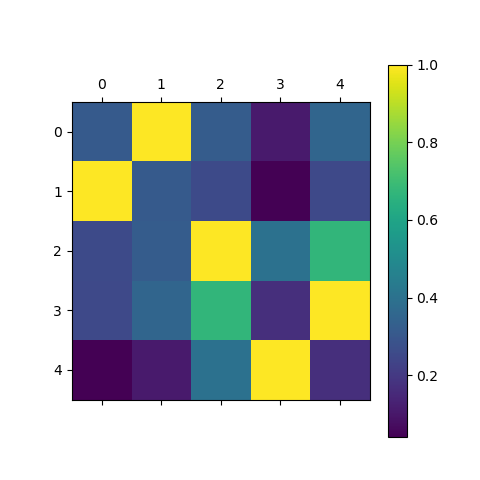

In [225]:
plt.matshow(np.abs(cosine_dist(data[:5, :test.shape[1]], test)))
plt.colorbar()